<a href="https://colab.research.google.com/github/irorohgloryebube/irorohgloryebube/blob/main/Copy_of_Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New Section

In [5]:
# install PySpark
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=aa87887123ef71aad8c7f7d5d8d7da12ab6cd17f916350c191b570c2d2c0d17b
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [6]:
from google.colab import drive

try:
    drive.mount('/content/drive')
    print("Drive mounted successfully!")
except Exception as e:
    print(f"Error mounting Google Drive: {e}")

Mounted at /content/drive
Drive mounted successfully!


In [7]:

import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, month

In [8]:
# Initialize Spark session
spark = SparkSession.builder.appName("AdventureWorks_Data_Analysis").getOrCreate()

# Load CSV file into PySpark DataFrame
file_path = '/content/drive/My Drive/SalesOrderDetail.csv'
sales_order_spark_df = spark.read.csv(file_path, header=True, inferSchema=True)

# Create temporary view for SQL queries
sales_order_spark_df.createOrReplaceTempView("sales_order")

# Example: Display schema and first few rows of DataFrame
sales_order_spark_df.printSchema()
sales_order_spark_df.show(5)

root
 |-- SalesOrderID: integer (nullable = true)
 |-- SalesOrderDetailID: integer (nullable = true)
 |-- CarrierTrackingNumber: string (nullable = true)
 |-- OrderQty: integer (nullable = true)
 |-- ProductID: integer (nullable = true)
 |-- SpecialOfferID: integer (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- UnitPriceDiscount: double (nullable = true)
 |-- LineTotal: double (nullable = true)
 |-- rowguid: string (nullable = true)
 |-- ModifiedDate: date (nullable = true)

+------------+------------------+---------------------+--------+---------+--------------+---------+-----------------+---------+--------------------+------------+
|SalesOrderID|SalesOrderDetailID|CarrierTrackingNumber|OrderQty|ProductID|SpecialOfferID|UnitPrice|UnitPriceDiscount|LineTotal|             rowguid|ModifiedDate|
+------------+------------------+---------------------+--------+---------+--------------+---------+-----------------+---------+--------------------+------------+
|       46929|   

In [9]:
# Extract data for the last two years
last_two_years_df = spark.sql("""
     SELECT *
     FROM sales_order
     WHERE ModifiedDate >= DATEADD(YEAR, -2, (SELECT MAX(ModifiedDate) FROM sales_order))
""")
last_two_years_df.show(5)

+------------+------------------+---------------------+--------+---------+--------------+---------+-----------------+---------+--------------------+------------+
|SalesOrderID|SalesOrderDetailID|CarrierTrackingNumber|OrderQty|ProductID|SpecialOfferID|UnitPrice|UnitPriceDiscount|LineTotal|             rowguid|ModifiedDate|
+------------+------------------+---------------------+--------+---------+--------------+---------+-----------------+---------+--------------------+------------+
|       46929|             12642|         F40B-49A9-87|       1|      808|             1|  24.2945|              0.0|  24.2945|A0BAC0E5-A591-4CA...|  2012-06-30|
|       46930|             12643|         73DA-4549-8B|       3|      712|             1|   5.1865|              0.0|  15.5595|7FD677C8-C52A-447...|  2012-06-30|
|       46930|             12644|         73DA-4549-8B|       2|      707|             1|  20.1865|              0.0|   40.373|43E40FA9-4363-4E9...|  2012-06-30|
|       46930|             1

In [12]:
# Calculate total sales per product
total_sales_per_product_df =last_two_years_df.groupBy("ProductID").sum("OrderQty").withColumnRenamed("sum(OrderQty)", "TotalSales")
total_sales_per_product_df.show(5)

+---------+----------+
|ProductID|TotalSales|
+---------+----------+
|      833|       186|
|      858|      2138|
|      897|         4|
|      808|       818|
|      883|      2848|
+---------+----------+
only showing top 5 rows



In [16]:
# Calculate monthly sales trends
month_year_extrations_df =last_two_years_df.withColumn("Year",year("ModifiedDate")).withColumn("Month", month("ModifiedDate"))
month_year_extrations_df .show(5)

+------------+------------------+---------------------+--------+---------+--------------+---------+-----------------+---------+--------------------+------------+----+-----+
|SalesOrderID|SalesOrderDetailID|CarrierTrackingNumber|OrderQty|ProductID|SpecialOfferID|UnitPrice|UnitPriceDiscount|LineTotal|             rowguid|ModifiedDate|Year|Month|
+------------+------------------+---------------------+--------+---------+--------------+---------+-----------------+---------+--------------------+------------+----+-----+
|       46929|             12642|         F40B-49A9-87|       1|      808|             1|  24.2945|              0.0|  24.2945|A0BAC0E5-A591-4CA...|  2012-06-30|2012|    6|
|       46930|             12643|         73DA-4549-8B|       3|      712|             1|   5.1865|              0.0|  15.5595|7FD677C8-C52A-447...|  2012-06-30|2012|    6|
|       46930|             12644|         73DA-4549-8B|       2|      707|             1|  20.1865|              0.0|   40.373|43E40FA9

In [18]:
monthly_sales_trends_df = month_year_extrations_df .groupBy("ProductID","Year", "Month").sum("OrderQty").withColumnRenamed("sum(OrderQty)","MonthlySales").orderBy("MonthlySales", ascending=False)
monthly_sales_trends_df.show(5)

+---------+----+-----+------------+
|ProductID|Year|Month|MonthlySales|
+---------+----+-----+------------+
|      870|2014|    3|         851|
|      864|2014|    3|         687|
|      712|2014|    3|         663|
|      870|2014|    5|         642|
|      870|2013|    7|         603|
+---------+----+-----+------------+
only showing top 5 rows



In [22]:
#Data Aggregation and Analysis

total_sales_per_product_df.createOrReplaceTempView("total_sales_per_product")
result_df = spark.sql("""
    SELECT ProductID, TotalSales
    FROM total_sales_per_product
    ORDER BY TotalSales DESC
""")

result_df.show(5)

+---------+----------+
|ProductID|TotalSales|
+---------+----------+
|      712|      7111|
|      870|      6815|
|      711|      5905|
|      708|      5779|
|      707|      5540|
+---------+----------+
only showing top 5 rows



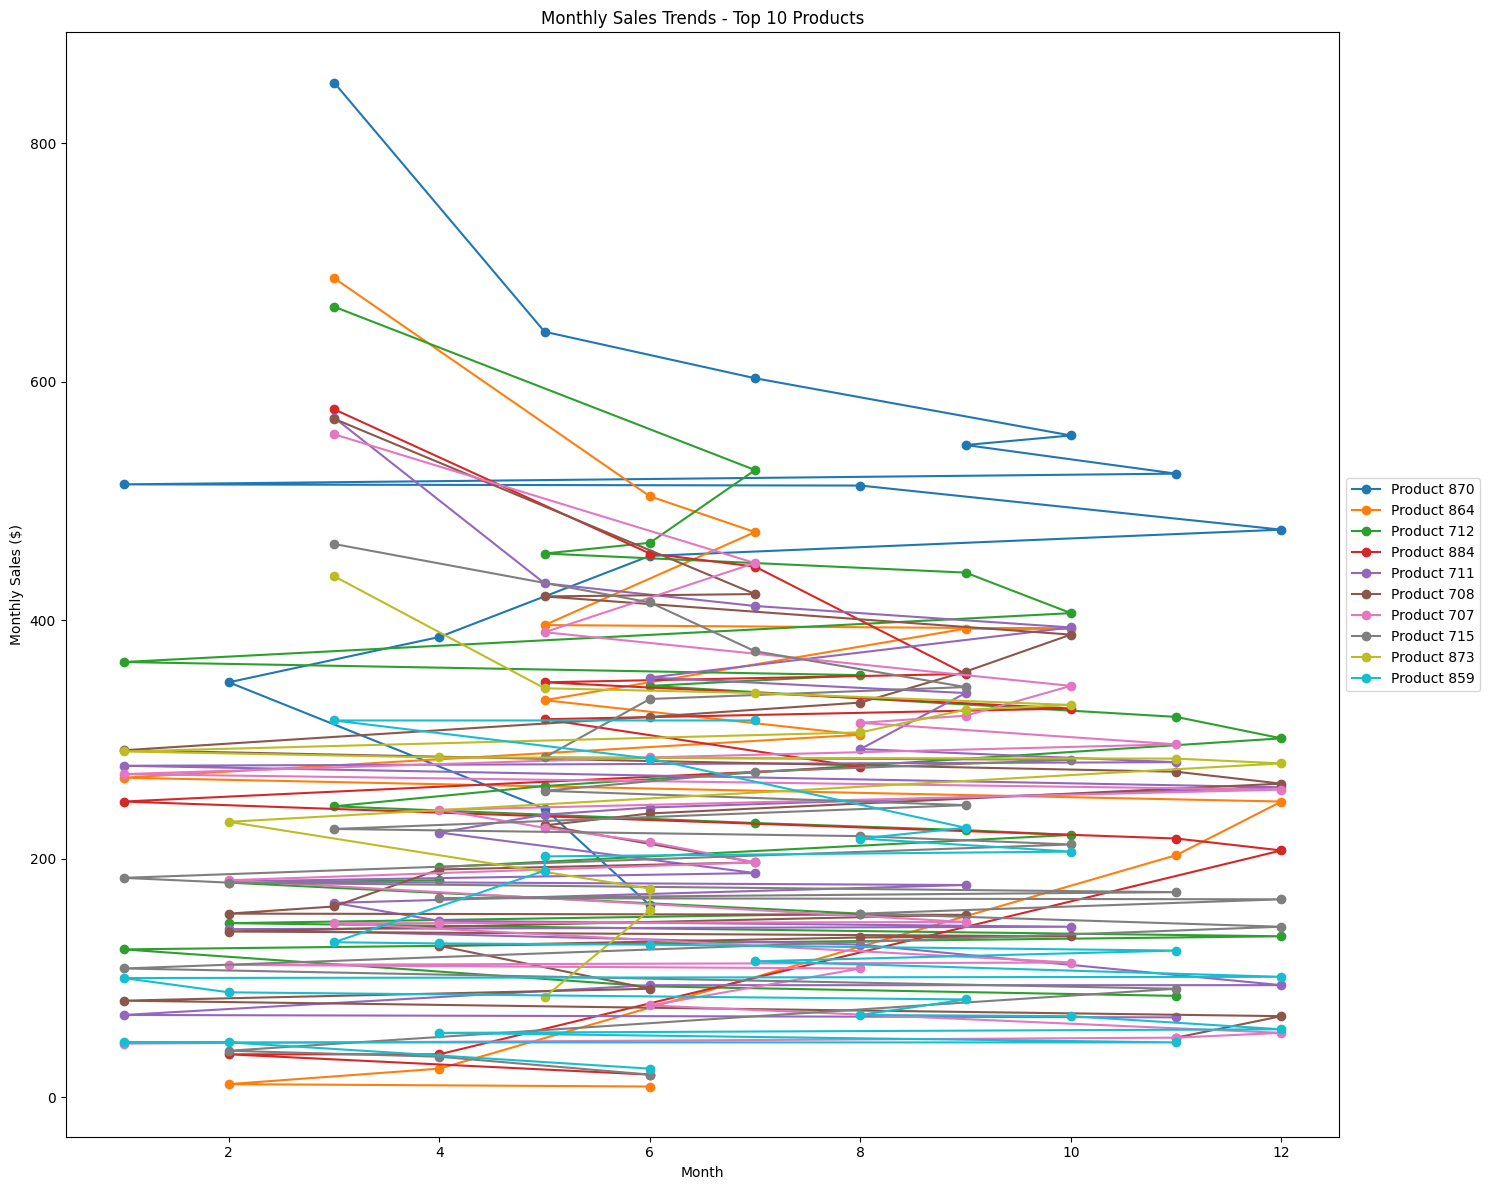

In [37]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert PySpark DataFrame to Pandas DataFrame
monthly_sales_trends_pd_df = monthly_sales_trends_df.toPandas()

# Calculate total sales for each product
product_sales = monthly_sales_trends_pd_df.groupby('ProductID')['MonthlySales'].sum().reset_index()

# Sort products by total sales and select top 10
top_10_products = product_sales.sort_values(by='MonthlySales', ascending=False).head(10)['ProductID']

# Filter data for top 10 products
top_10_data = monthly_sales_trends_pd_df[monthly_sales_trends_pd_df['ProductID'].isin(top_10_products)]

# Plotting monthly sales trends for top 10 products
plt.figure(figsize=(15, 12))
for product_id in top_10_data['ProductID'].unique():
    product_data = top_10_data[top_10_data['ProductID'] == product_id]
    plt.plot(product_data['Month'], product_data['MonthlySales'], marker='o', label=f'Product {product_id}')

plt.xlabel('Month')
plt.ylabel('Monthly Sales ($)')
plt.title('Monthly Sales Trends - Top 10 Products')

# Place legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(False)
plt.tight_layout()
plt.show()


